In [59]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, RandomFlip# type: ignore
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix
main_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\Tuberculosis (TB) Chest X-ray Database\\TB_Chest_Radiography_Database"
directories = os.listdir(main_path)
images = []
labels = []
for direct in directories:
    #print(direct)
    path1 = main_path+"\\"+direct
    files = os.listdir(path1)
    if direct == "Normal":
        code = 0
    elif direct == "Tuberculosis":
        code = 1
    
    counter = 0
    for file in files:
        if counter <2600:
            img = cv2.imread(main_path+"\\"+direct+"\\"+file)
            img = cv2.resize(img, (200,200))
            labels.append(code)
            images.append(img)
            counter += 1


In [60]:
images = np.asarray(images)
labels = np.asarray(labels)
display("Shape of Images" , images.shape, "Label Shape", labels.shape)

'Shape of Images'

(3300, 200, 200, 3)

'Label Shape'

(3300,)

In [61]:
data = images/255.0

In [62]:
X_train,X_test_combined, y_train, y_test_combined = train_test_split(data, labels, test_size=0.4, shuffle=True)


In [63]:
X_val, X_test, y_val, y_test = train_test_split(X_test_combined, y_test_combined, test_size=0.5, shuffle=True)

In [64]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(200, 200, 3))

In [65]:


x = base_model.output
print(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation= 'sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

<KerasTensor shape=(None, 6, 6, 512), dtype=float32, sparse=False, name=keras_tensor_168>


In [66]:
for layer in model.layers[:-3]:
    layer.trainable = False
    

In [67]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [68]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - binary_accuracy: 0.8277 - loss: 0.8710 - val_binary_accuracy: 0.9864 - val_loss: 0.0500
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - binary_accuracy: 0.9831 - loss: 0.0483 - val_binary_accuracy: 0.9894 - val_loss: 0.0369
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - binary_accuracy: 0.9956 - loss: 0.0223 - val_binary_accuracy: 0.9970 - val_loss: 0.0265
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - binary_accuracy: 0.9967 - loss: 0.0136 - val_binary_accuracy: 0.9924 - val_loss: 0.0286
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - binary_accuracy: 0.9996 - loss: 0.0074 - val_binary_accuracy: 0.9818 - val_loss: 0.0475
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - binary_accuracy: 1.0000 - loss: 0.0061 - val_binary_accuracy: 0.9803 - val_loss: 0.0537
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - binary_accuracy: 0.9999 - loss: 0.0050 - val_binary_accuracy: 0.9955 - val_loss: 0.0216
Epoch 8/10
62

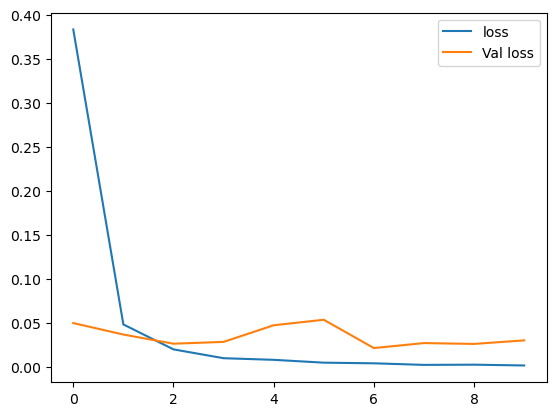

In [69]:
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

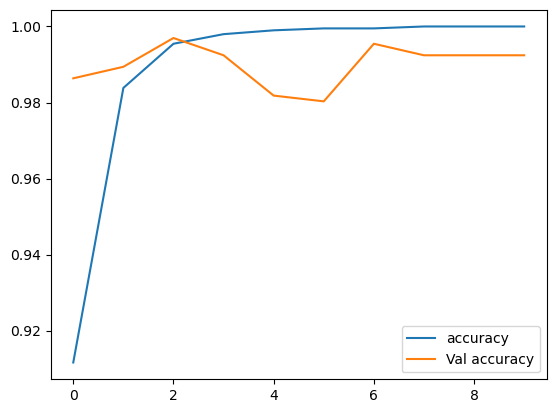

In [70]:
plt.plot(model.history.history['binary_accuracy'], label='accuracy')
plt.plot(model.history.history['val_binary_accuracy'], label='Val accuracy')
plt.legend()
plt.show()

In [71]:
result = model.evaluate(X_test, y_test, batch_size=32)


print(f'The accuracy is {result[1]}')
print(f'The loss is {result[0]}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - binary_accuracy: 0.9918 - loss: 0.0229
The accuracy is 0.9924242496490479
The loss is 0.023998692631721497


In [72]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


y_pred = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step


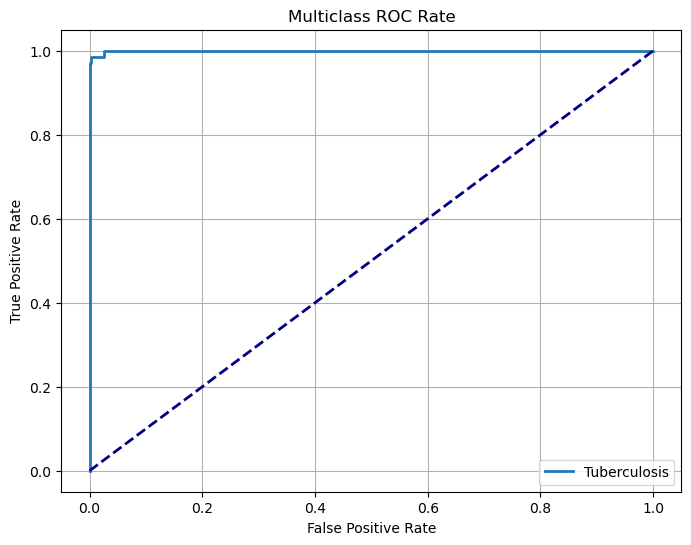

AUROC for class Tuberculosis : 1.000


In [73]:
y_true = y_test
n_classes = 2
fpr = {}
tpr = {}
# roc_auc = {}
classes_names = {0:"Normal", 1:"Tuberculosis"}
classes_names_list = ["Tuberculosis"]


fpr, tpr,  _ =  roc_curve(y_true, y_pred)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8,6))

plt.plot(
    fpr, tpr, 
    lw=2,
    label=f"Class {1} (area = {roc_auc:.3f})"
)

plt.plot([0,1], [0,1], color="navy", lw=2, linestyle= "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Rate")
plt.legend(classes_names_list, loc="lower right")
plt.grid()
plt.show()


print(f"AUROC for class {classes_names[1]} : {roc_auc:.3f}")


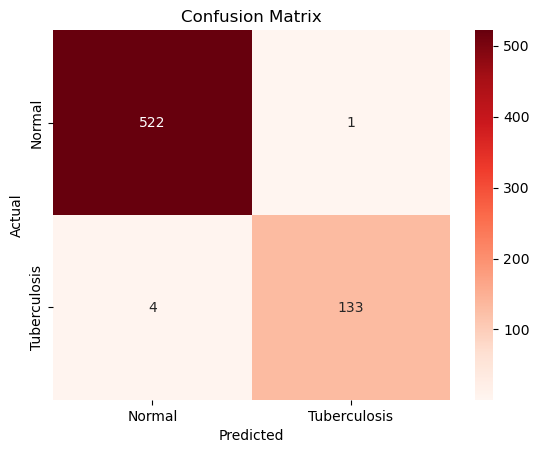

In [74]:
cm = confusion_matrix(y_true=y_true, y_pred=np.round(y_pred))

sns.heatmap(cm, cmap="Reds", 
            annot=True, 
            fmt='g',
            xticklabels=["Normal","Tuberculosis"],
            yticklabels=["Normal","Tuberculosis"],
            )

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [75]:
print(f"Sensitivity to correctly classifiy a CXR with TB {cm[1][1]/(cm[1][1]+cm[1][0]):.3f}")
print(f"Specificity to correctly classifiy a CXR with TB {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")

Sensitivity to correctly classifiy a CXR with TB 0.971
Specificity to correctly classifiy a CXR with TB 0.993


In [76]:

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,872,005 (110.14 MB)

 Trainable params: 4,719,105 (18.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 9,438,212 (36.00 MB)

In [77]:
model.save("cxr_Normal_tb_vgg16_model.keras")

In [78]:
from tensorflow.keras.models import load_model
model = load_model("cxr_Normal_tb_vgg16_model.keras")

Next Steps
1. Train on more data
2. Augument the Data
3. Create a model that identifies if an image is a CXR before predicting if TB is present or not 
4. Send an Alert is TB is likely
5. Segment Abnormal area